<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installs

In [1]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=5d07ca75fd33aacb0d56e94cfc2f949b78f139898b5ee88c9de260751833ca5d
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends
     |████████████████████████████████| 40 kB 4.2 MB/s 
     |████████████████████████████████| 161 kB 14.1 MB/s 
  Created wheel for openai: filename=openai-0.15.0-py3-none-any.whl size=50093 sha256=826e36036753eebd2abc64ec07f6f8bdfa2ee55de6fe0277dd70c07f674b5158
  Stored in directory: /root/.cache/pip/wheels/bd/b1/b5/01a94056fd87ef0ed913b2fa6f1161076b730cf1449f579ab7
Successfully built openai


## imports

In [2]:
import numpy
import pandas 
import re
import string

import time 
from difflib import SequenceMatcher

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 

import openai

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

# supply openai api key via file 
openai.api_key = open('openai_key').read()


## seed config

In [3]:
# connection strenth minimum boost, base on standard deviation
std_factor = .5
pop_threshold = .3

# batch size
batch_size = 30

# request object
req_obj = ['diseases', 'symptoms', 'behaviors', 'objects', 'emotions', 'home remedies', 'products', 'complications', 'cities', 'styles']

#req_obj = ['concepts', 'styles', 'cities', 'emotions']

# seed topics

# topics = ['dance', 'travel', 'music', 'sports', 'cooking', 'nightlife', 'boat', 'car', 'coffee', 'steak', 'turkey']

topics = ['Heart', 'Stomach', 'Feet', 'Knees', 'Legs', 'Elbow', 'Head', 'Neck', 'Back', 'Nose', 'Mouth', 'Shoulder', 'Hip', 'Thigh', 'Liver', 'Colon', 'Intestines']

#topics = ['Asthma', 'Bronchitis', 'Sinusitis', 'Emergency', 'Walgreens', 'Cvs', 'Eye', 'Knee', 'Skull', 'Ear', 'Nose', 'Rash', 'Arthritis'
#        , 'Tinnitus', 'Burn', 'Allergy', 'Ambulance', 'Accident', 'Poison', 'Cough', 'Watery eye', 'Ringworm', 'Antibiotic', 'Doctor', 'Clinic'
#        , 'Hypertension', 'Pharmacy', 'Primary care', 'Bruise', 'Sprain', 'Strain', 'Exczema', 'Cellulitis', 'Abscesses', 'Strep throat'
#        , 'Pain', 'Throbbing', 'Irritability', 'Sad', 'Happy', 'Mad' , 'Cancer', 'Surgery', 'Heart', 'Lungs', 'Throat', 'Mouth', 'Toothache'
#        , 'Ear infection', 'Diabetes', 'Migranes', 'Pink eye', 'Bladder infection', 'Attention deficit', 'Depression', 'Anxiety']

#topics = ['headache', 'knee pain', 'lump', 'blurry vision']


## helper functions
  1. get_trend_frame(topics, years): returns a dataframe of topic trends
  2. stack_nodes_vertically(df_features):
  3. build_node_labels(df_flat):

In [4]:
### 1. for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years):

  # batch management
  batch_counter = 0
  batch_idx = 0

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided 
  for topic in topics:

    # prevent saturation of api endpoint
    if batch_counter > batch_size:
      print('')
      batch_idx+=1
      print('completed retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(topics) ))
      batch_counter=0
      time.sleep(30)


    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,geo="US-TX"
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    batch_counter+=1

    try:

      # add column for new topic
      df_total[topic] = df[topic]

    except:
      print('failed to add topic - %s ' % (topic))

  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [5]:
### 2. for each topic and interval of time, stack a vertical dataframe of value counts
def stack_nodes_vertically(df_features):

  # initialize buffers resources
  df_stk=pandas.DataFrame()
  globalst=[]

  # for each feature
  for col in df_features:                      # topic

      # for each time interval
      for val in df_features.index.weekofyear: # weeknum

          try:

            # time sensitive
            fs_val = df_features[col][val]       # full spectrum
                
            if fs_val > pop_threshold:

              # iterate through each instance of max bin occurence, determining number of weeks written
              for x in range(0,int(abs(fs_val) * 100)):
                
                  # build buffer list
                  lst = [val, val, col]
                  globalst.append(lst)

            else:
                  # build buffer list
                  lst = [val, None, None]
                  globalst.append(lst)

          except Exception as e: # work on python 3.x
              print(col)              
              print(val)
              print(fs_val)
              print('Failed to upload to ftp: '+ str(e))

  # materialize vertically flattened
  df_flat = pandas.DataFrame(globalst
                            ,columns=['WeekNum'
                            ,'WeekNum_Rct'
                            ,'Flower_Tot'])
  
  return df_flat

In [6]:
### 3. prefix ridgemap/joyplot labels with weeknum average
def build_node_labels(df_flat):
  
  # get all distinct nodes
  df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()

  # rename columns to node labels
  df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]

  # sort by average time interval
  df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

  # include average into node label
  df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

  # update flattened node space with averaged names
  for index, row in df_stats.iterrows():
      df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])

  return df_flat

In [7]:
### 4. display ridgeplot of time frame, for 
def get_ridgeplot(df_flat):

  # configure and build ridgeplot
  fig, axes = joypy.joyplot(df_flat
                            , column=['WeekNum', 'WeekNum_Rct']
                            , by='Flower_Tot'
                            , overlap=1.2
                            , fill=True
                            , figsize=(22,22)
                            , x_range = [0,52]
                            , colormap=cm.cool                         
                            , ylim='own'
                          )

  # write ridgeplot
  plt.savefig('frank_jj.png')

  # plot
  plt.show()

In [8]:
### 5. send openai question, receive response
def get_openai_response(question):

    # format open au request
    response = openai.Completion.create(
                      engine="text-davinci-001",
                      prompt=question,
                      temperature=.01,
                      max_tokens=250,
                      top_p=1,
                      frequency_penalty=50,
                      presence_penalty=0 )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip('\n')

    return response

In [9]:
def swap_tokens(chk_topics, new_topics):

  buffer_lst = []

# for each graphed topics
  for chk_topic in chk_topics:

    buffer_lst.append(chk_topic)


  for new_topic in new_topics:

    # token validation checks

      new_topic_split = new_topic.split()
    
    # 1. check that not preceeded by short word
      if len(new_topic_split[0]) < 3:

        try:
          new_topic = new_topic_split[1]
        except:
          pass
        

      buffer_lst.append(new_topic)


  return buffer_lst


In [10]:
def get_pairwise_similarity(df_features, topics, std_factor):

  # pair wise correlation / similarity
  c = df_features.corr().abs()

  # flatten and sort
  so = c.unstack().sort_values(kind="quicksort")

  # remove low connections
  min_connection_strength = so.mean() + ( std_factor * so.std() )
  min_connection_cutoff = len(so) - len(so[so > min_connection_strength])

  # turn to frame
  df_slice = so[min_connection_cutoff:-len(topics)].to_frame()

  df_slice.reset_index(inplace=True)

  df_slice.columns = ['source','target','weight']

  return df_slice

In [11]:
def build_graph_network(df_slice):

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'source'          # parent
                            ,'target'          # child
                            , ['weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 


  # visualize graph 
  nx.draw_spring(G                        
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='white'
      ,font_size=22)
  
  return G

In [12]:
def get_openai_generated_topics(topic, obj):
  
  new_tokens_list = []

  responses = []

  # retrieve 
  retrieval = get_openai_response('from the perspetive of a Texas resident, list one word %s related to %s' % (obj , topic))
  responses.append(retrieval)

  new_tokens = re.split("; |, |\*|\n",responses[0].lower())
  #new_tokens = re.split("; |, |\*|\n",retrieval.lower())
  #new_tokens_list.append(' '.join(new_tokens))


  return new_tokens

In [13]:
def get_related_topics(df):

  lst_buffer = []
  graph_topics = list(df['source'].unique())

  # batch management
  batch_counter = 0
  batch_idx = 0

  for graph_topic in graph_topics:

    for obj in req_obj:

      # prevent saturation of api endpoint
      if batch_counter > batch_size:
        print('')
        batch_idx+=1
        print('completed openai retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(graph_topics) * len(req_obj) ))
        batch_counter=0
        time.sleep(30)

      topic_list = get_openai_generated_topics(graph_topic, obj)

      for topic in topic_list:

        topic = topic.translate(string.punctuation)
        topic = re.sub(r'[^\w\s]','',topic)

        if len(topic) < 10 and len(topic) > 4:

          lst_buffer.append(topic)
      
      batch_counter+=1
    
  return lst_buffer

## gather, pre-process and stage graph data structure

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


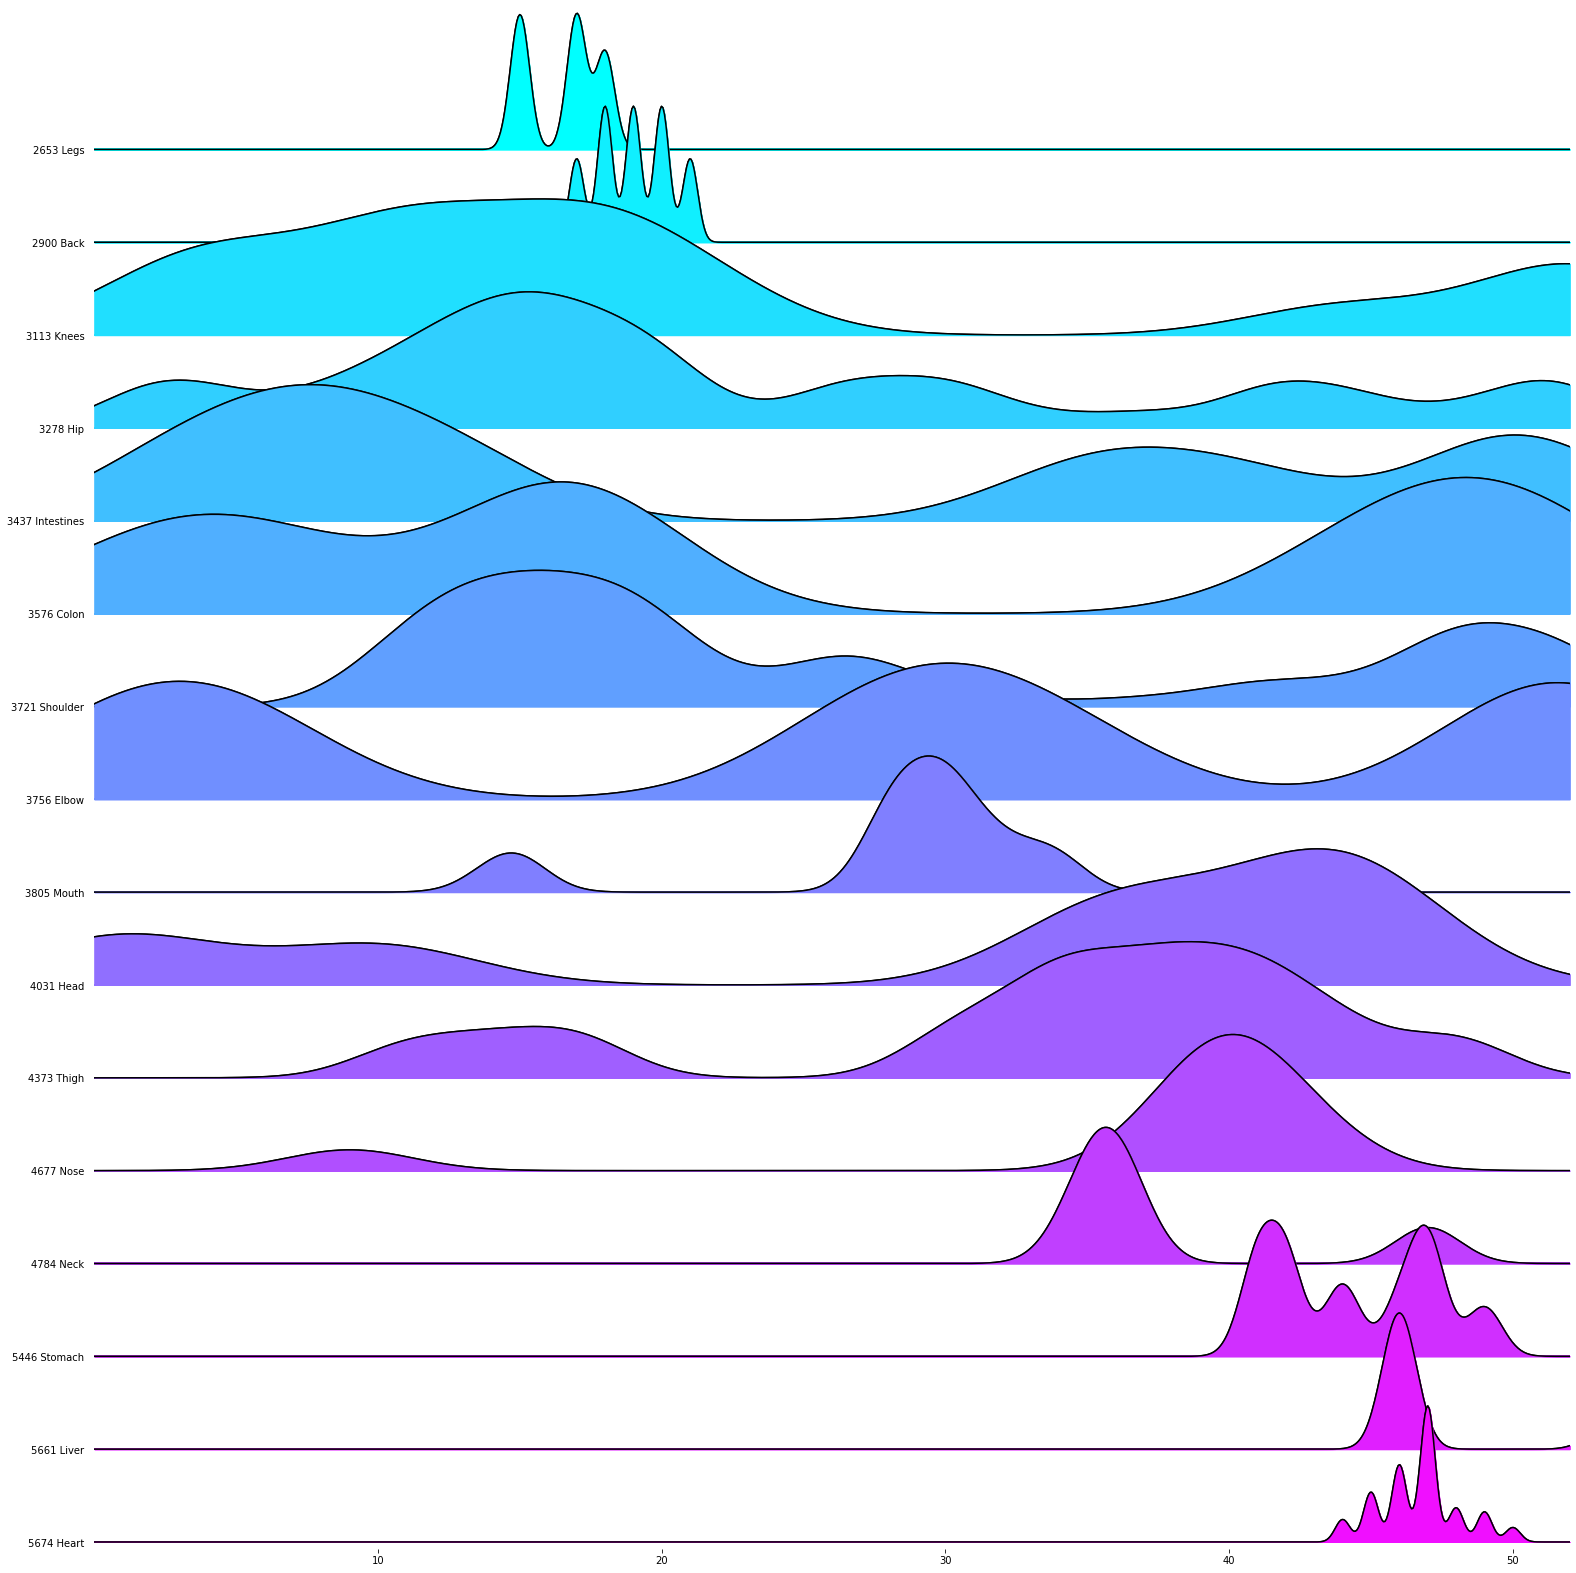

In [14]:
# request features
df_features = get_trend_frame(topics, '5')[topics]

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

In [15]:
df_features
#df_slice

Heart   Stomach      Feet     Knees      Legs     Elbow  \
date                                                                     
2017-03-19  0.478294 -0.113650 -0.666776  0.420340 -0.166446  0.573336   
2017-03-26 -0.030321 -0.428001 -0.811244  0.163191 -1.060050  0.751221   
2017-04-02  0.096832 -0.585177 -0.811244 -0.608256 -1.060050 -0.849742   
2017-04-09 -0.157475 -0.742352 -0.811244  0.677489 -0.677077 -1.027627   
2017-04-16 -0.284629 -0.585177 -0.955712 -1.122554 -0.677077 -0.849742   
...              ...       ...       ...       ...       ...       ...   
2022-02-06  3.911446  0.986579  0.344501  1.706085  0.216527  0.751221   
2022-02-13  3.275677  1.615281  0.777905  0.420340 -0.294104 -0.316088   
2022-02-20  0.096832  1.143755  0.922373  1.320361  0.982473 -0.316088   
2022-02-27  0.096832  1.772457  0.777905  0.548914 -0.294104  0.573336   
2022-03-06  0.478294  1.615281  1.355778 -0.736831  0.216527  1.996415   

                Head      Neck      Back      Nose     Mouth  Shoulder  \
date                                                                     
2017-03-19 -0.445290 -0.785311 -1.013221 -1.109054 -0.304102 -0.441120   
2017-03-26  0.786363 -0.591223 -0.849494 -1.537515 -0.809857 -0.064466   
2017-04-02 -0.198959 -1.561665 -1.176949 -1.430399 -1.989953 -0.629447   
2017-04-09 -0.691620 -1.561665 -0.685766 -1.751745 -1.484198 -0.629447   
2017-04-16 -0.445290 -1.755753 -0.849494 -1.430399 -0.809857 -0.064466   
...              ...       ...       ...       ...       ...       ...   
2022-02-06  2.264345  0.573307  0.460326  1.033249 -0.135517  0.688843   
2022-02-13  0.540032  0.185130  0.460326  1.140364 -0.978442  0.500516   
2022-02-20  0.293702  0.185130 -0.030856  0.926134 -0.978442  1.253825   
2022-02-27  0.047371 -0.397135 -0.358311  1.461710 -0.304102  0.123861   
2022-03-06  0.540032 -0.008958 -1.176949  1.140364 -0.809857  0.123861   

                 Hip     Thigh     Liver     Colon  Intestines  
date                                                            
2017-03-19  2.324479 -0.862401 -0.492967 -0.182169   -0.699674  
2017-03-26  1.074148 -1.321564 -1.328348  0.400771   -0.873257  
2017-04-02  1.301481 -2.239889 -0.850987 -0.182169    0.688992  
2017-04-09  1.415147 -2.392943 -0.492967  0.109301   -1.654382  
2017-04-16  0.960481 -2.086835 -0.731647  0.546506    0.949367  
...              ...       ...       ...       ...         ...  
2022-02-06 -0.062517  1.280357  1.535816  0.400771    0.081451  
2022-02-13 -0.289849  1.127303  0.939115  0.109301    0.602200  
2022-02-20 -1.199181  0.821195  1.177796  0.400771   -0.439299  
2022-02-27 -1.085514  0.821195  2.251857 -0.036434    0.341826  
2022-03-06 -0.630849  0.821195  2.132517  0.400771   -0.612883  

[260 rows x 17 columns]

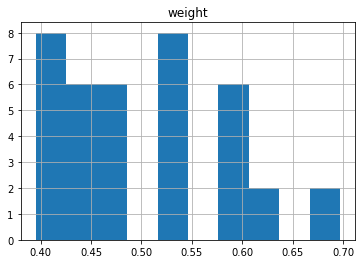

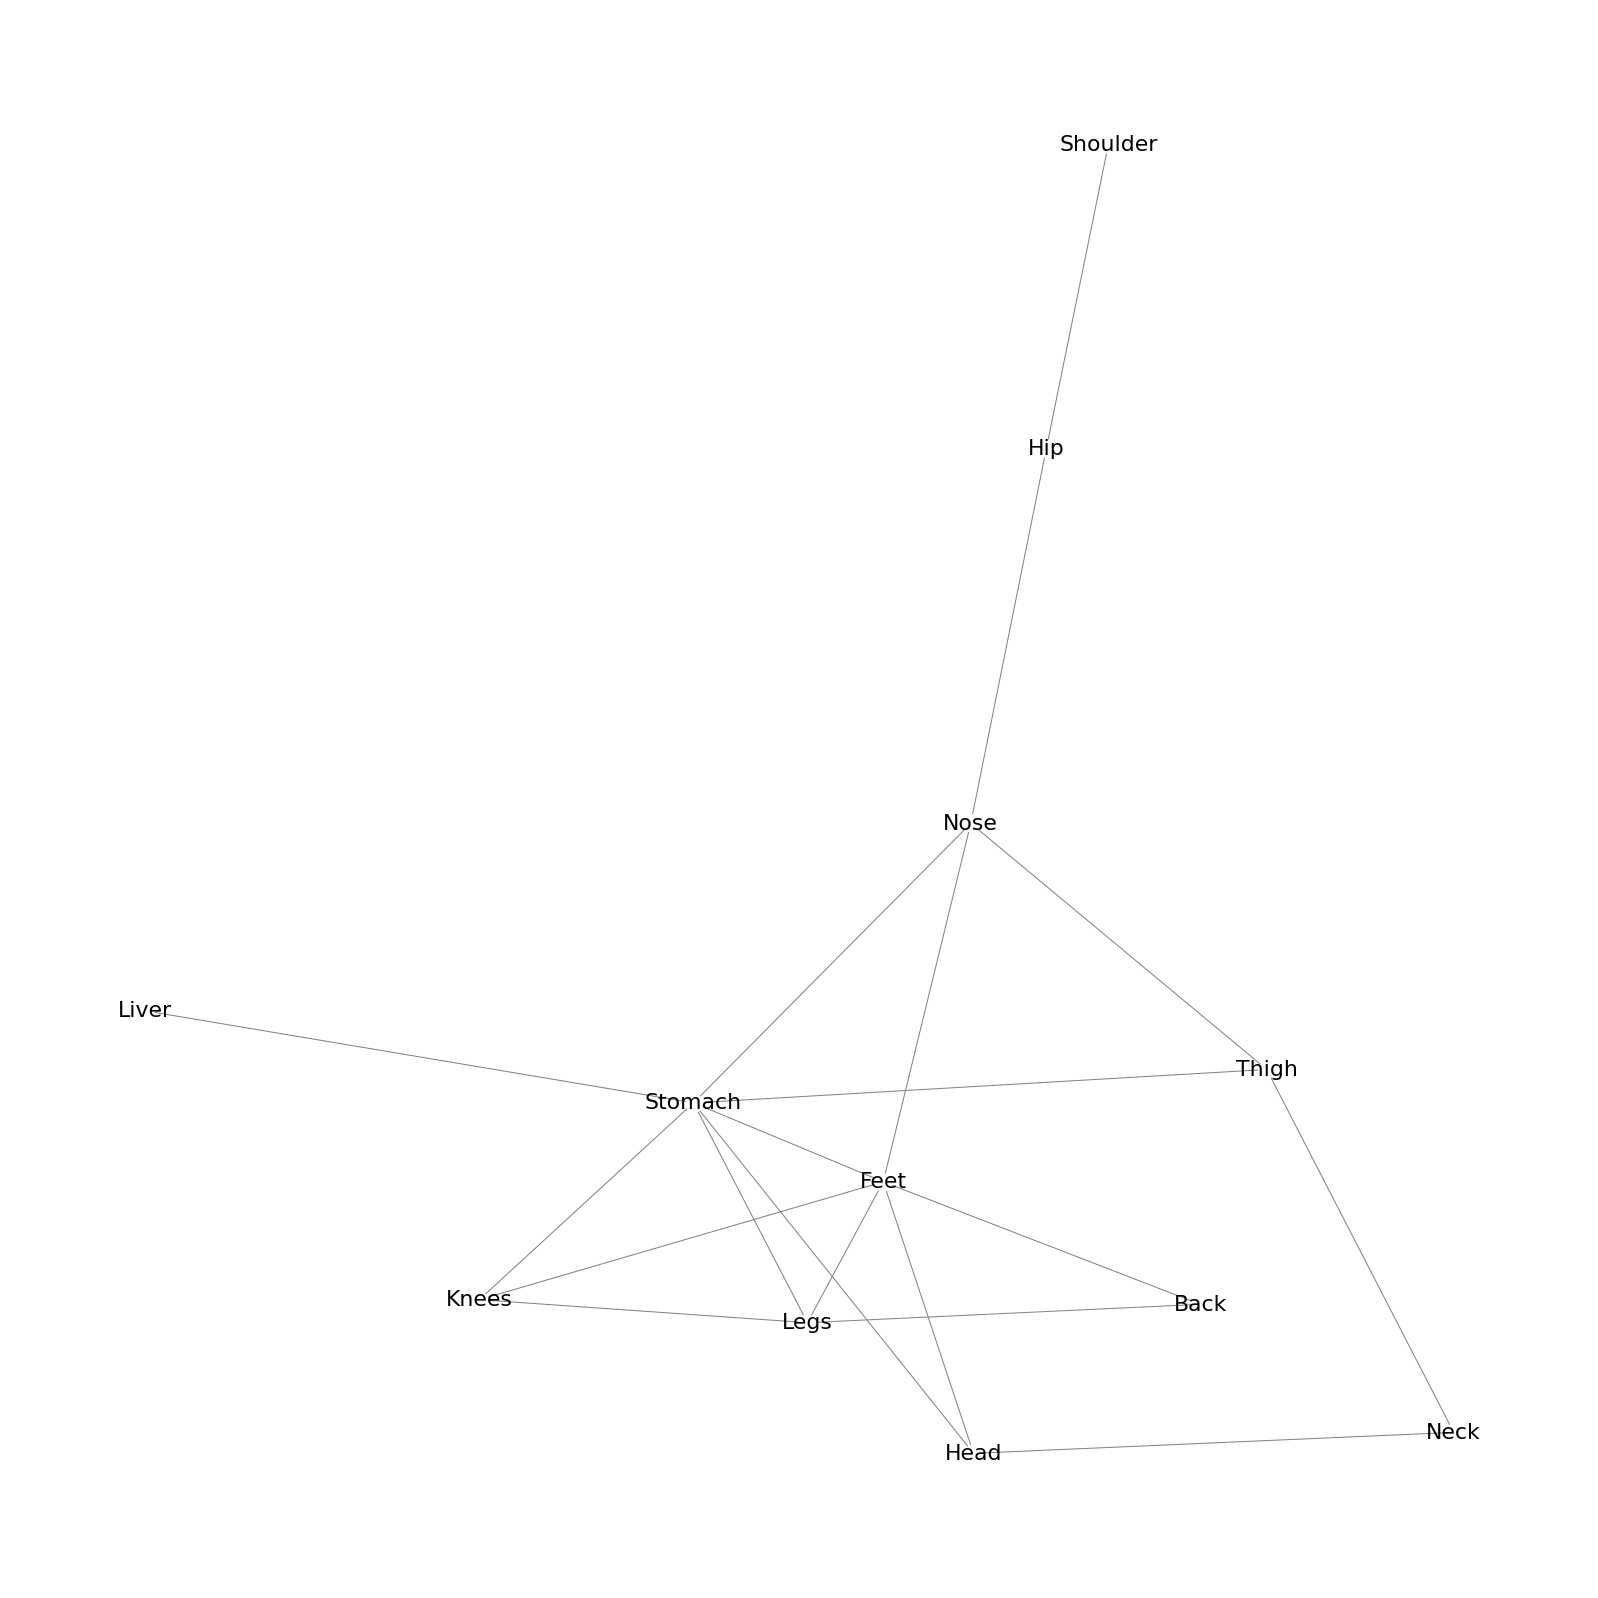

In [16]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, topics, std_factor)

# reduce to realistic relationship weights
#df_slice = df_slice[(df_slice['weight']<0.85)]
#df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)

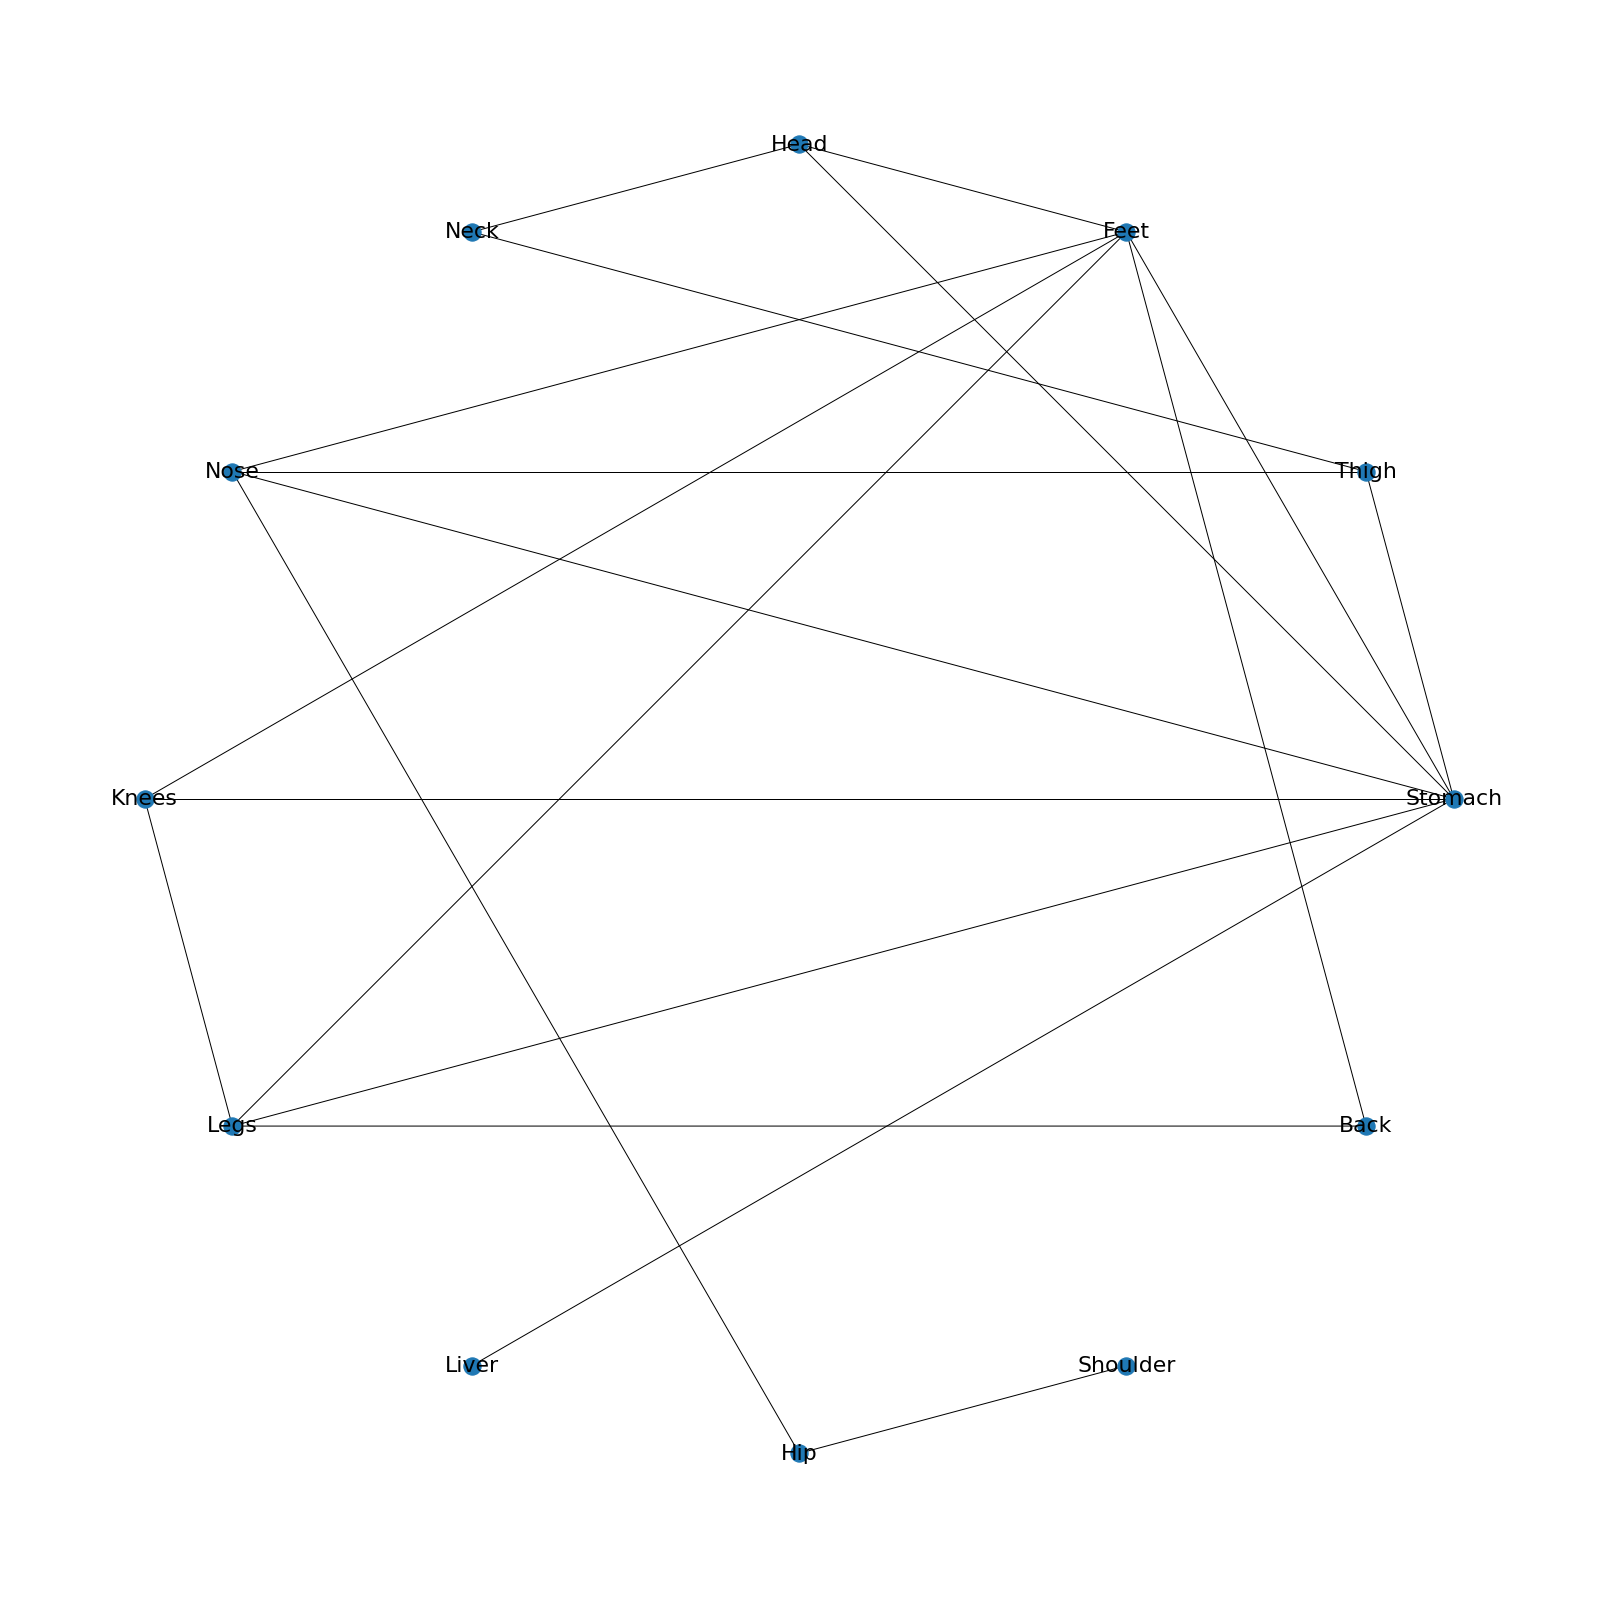

In [17]:
# circler plot
circ_pos = nx.circular_layout(G) 

# define plot area
plt.figure(3,figsize=(22,22)) 

#Use the networkx draw function to easily visualise the graph
nx.draw(G,circ_pos,with_labels=True,font_size=22)


In [18]:
# community detection

# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

Communities found - 3 

Community 0 - ['Head', 'Liver', 'Neck', 'Stomach', 'Thigh']
Community 1 - ['Back', 'Feet', 'Knees', 'Legs']
Community 2 - ['Hip', 'Nose', 'Shoulder']


In [19]:
### graph properties

# list nodes
G.nodes.items()

# number of edges in graph
G.number_of_edges()

# number of nodes in graph
G.number_of_nodes()

G.get_edge_data(0,1)

In [20]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice)
print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
print(gen_topics)


completed openai retrieval of batch 1 - 30 rows of 120

completed openai retrieval of batch 2 - 60 rows of 120

completed openai retrieval of batch 3 - 90 rows of 120
['nausea', 'vomiting', 'nausea', 'vomiting', 'hunger', 'nausea', 'vomiting', 'diarrhea', 'antacids', 'houston', 'dallas', 'queasy', 'cancer', 'infection', 'alluring', 'alluring', 'texas', 'cowboys', 'houston', 'dallas', 'glamorous', 'bunions', 'tired', 'walking', 'running', 'socks', 'shoes', 'tired', 'foot soak', 'socks', 'shoes', 'houston', 'dallas', ' lice', 'pressure', ' texans', 'loyal', 'river', 'water', 'angry', 'massage', 'ice pack', 'shampoo', 'houston', 'dallas', 'arthritis', ' pain', 'stiffness', 'necking', 'necklace', ' deep', 'happiness', ' pain', 'texas', 'products', 'houston', 'dallas', 'laces', 'chunky', 'colorful', 'sinusitis', 'bleeds', 'y parkers', 'intrusive', 'bleeds', 'boogers', 'houston', 'dallas', 'intrusive', 'arthritis', 'bursitis', 'swelling', 'bending', 'kneeling', 'relief', 'arthritis', 'ice p


completed retrieval of batch 1 - 30 rows of 98
failed to add topic - sterism 

completed retrieval of batch 2 - 60 rows of 98

completed retrieval of batch 3 - 90 rows of 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


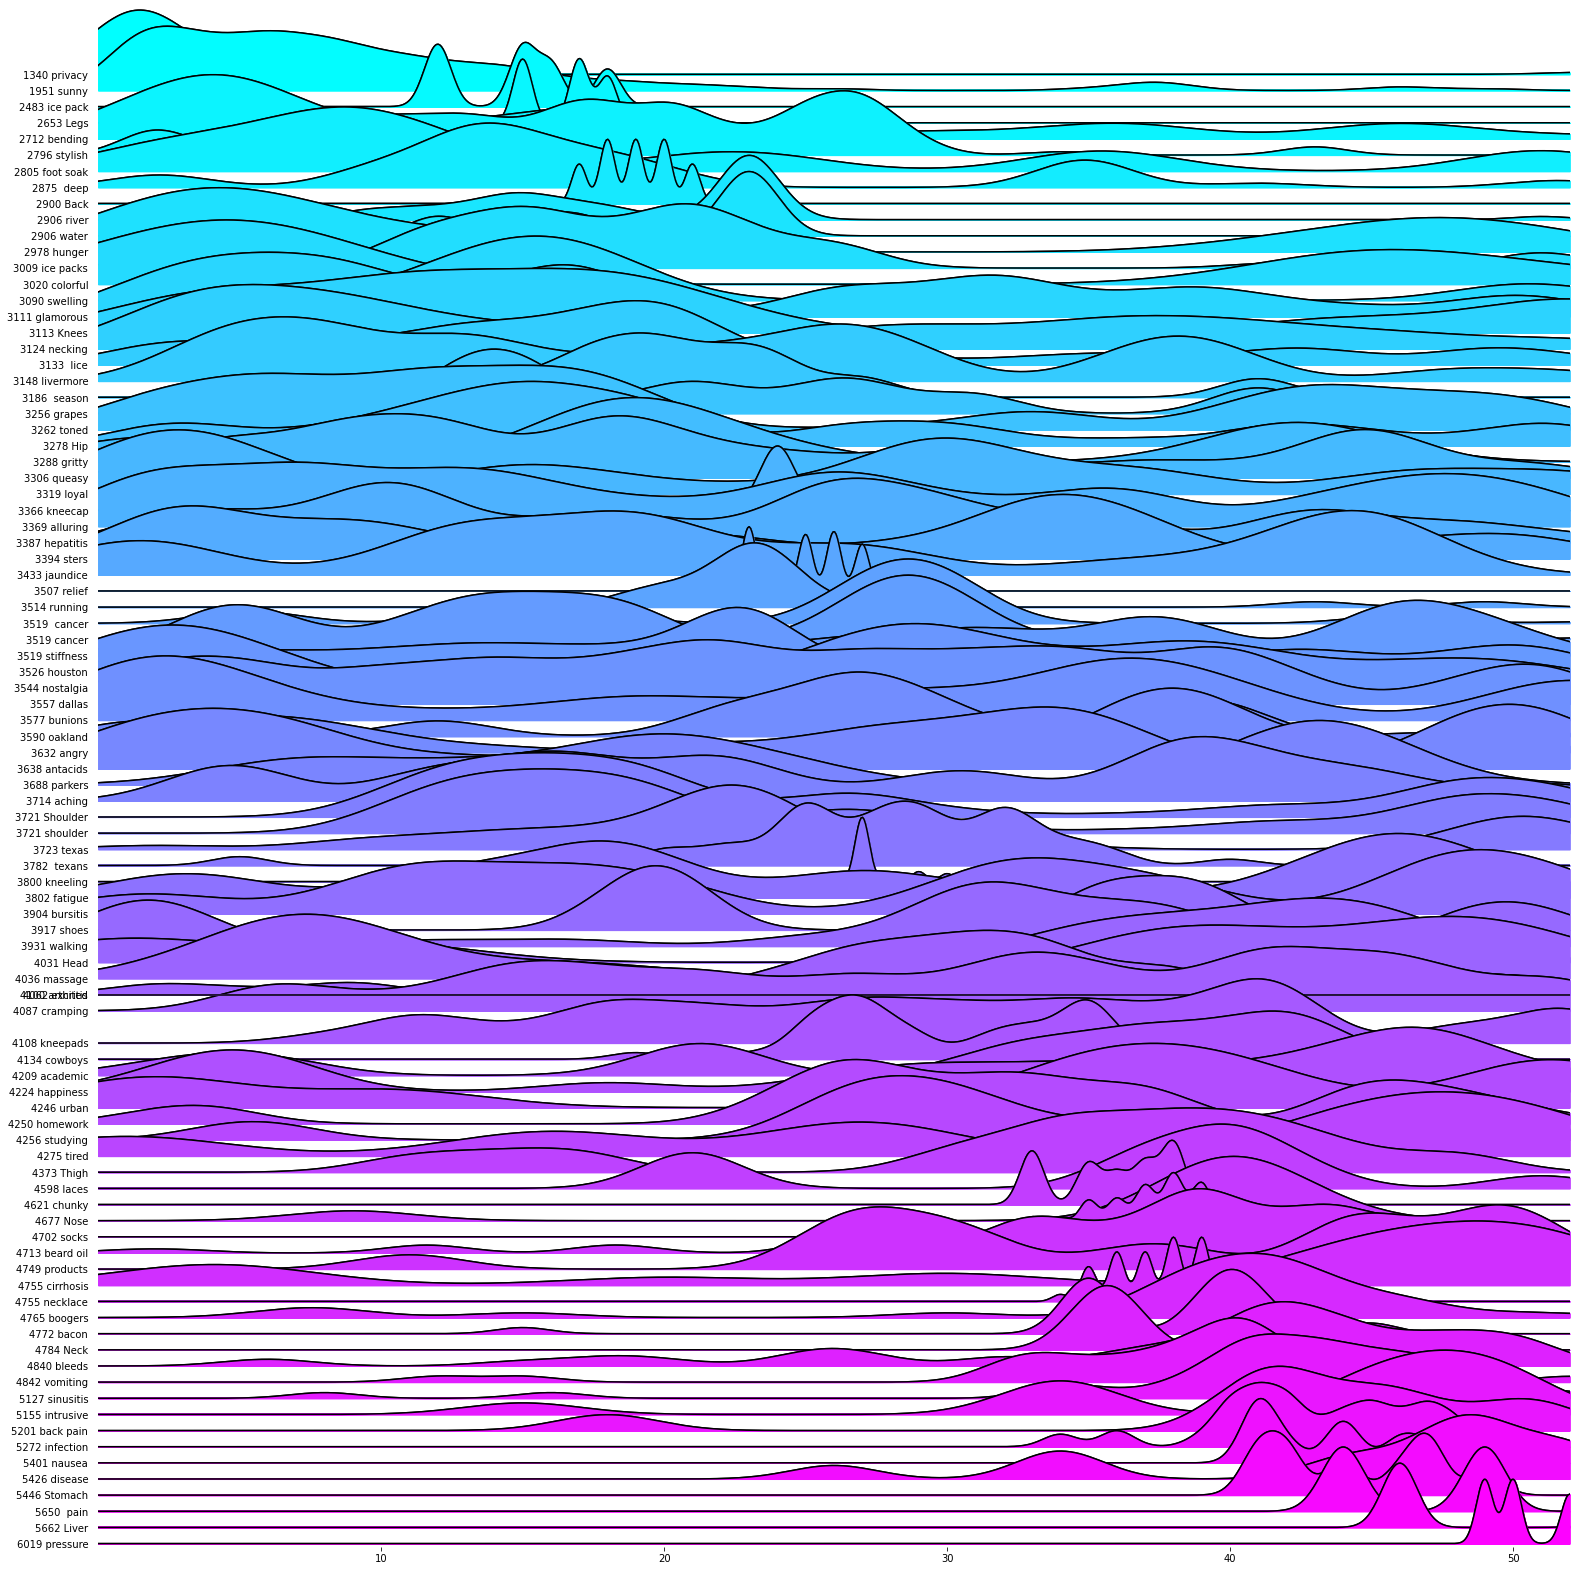

In [24]:
# request features
#df_features = get_trend_frame(gen_topics, '5')[gen_topics]
df_features = get_trend_frame(gen_topics, '5')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

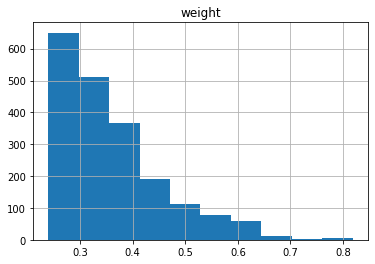

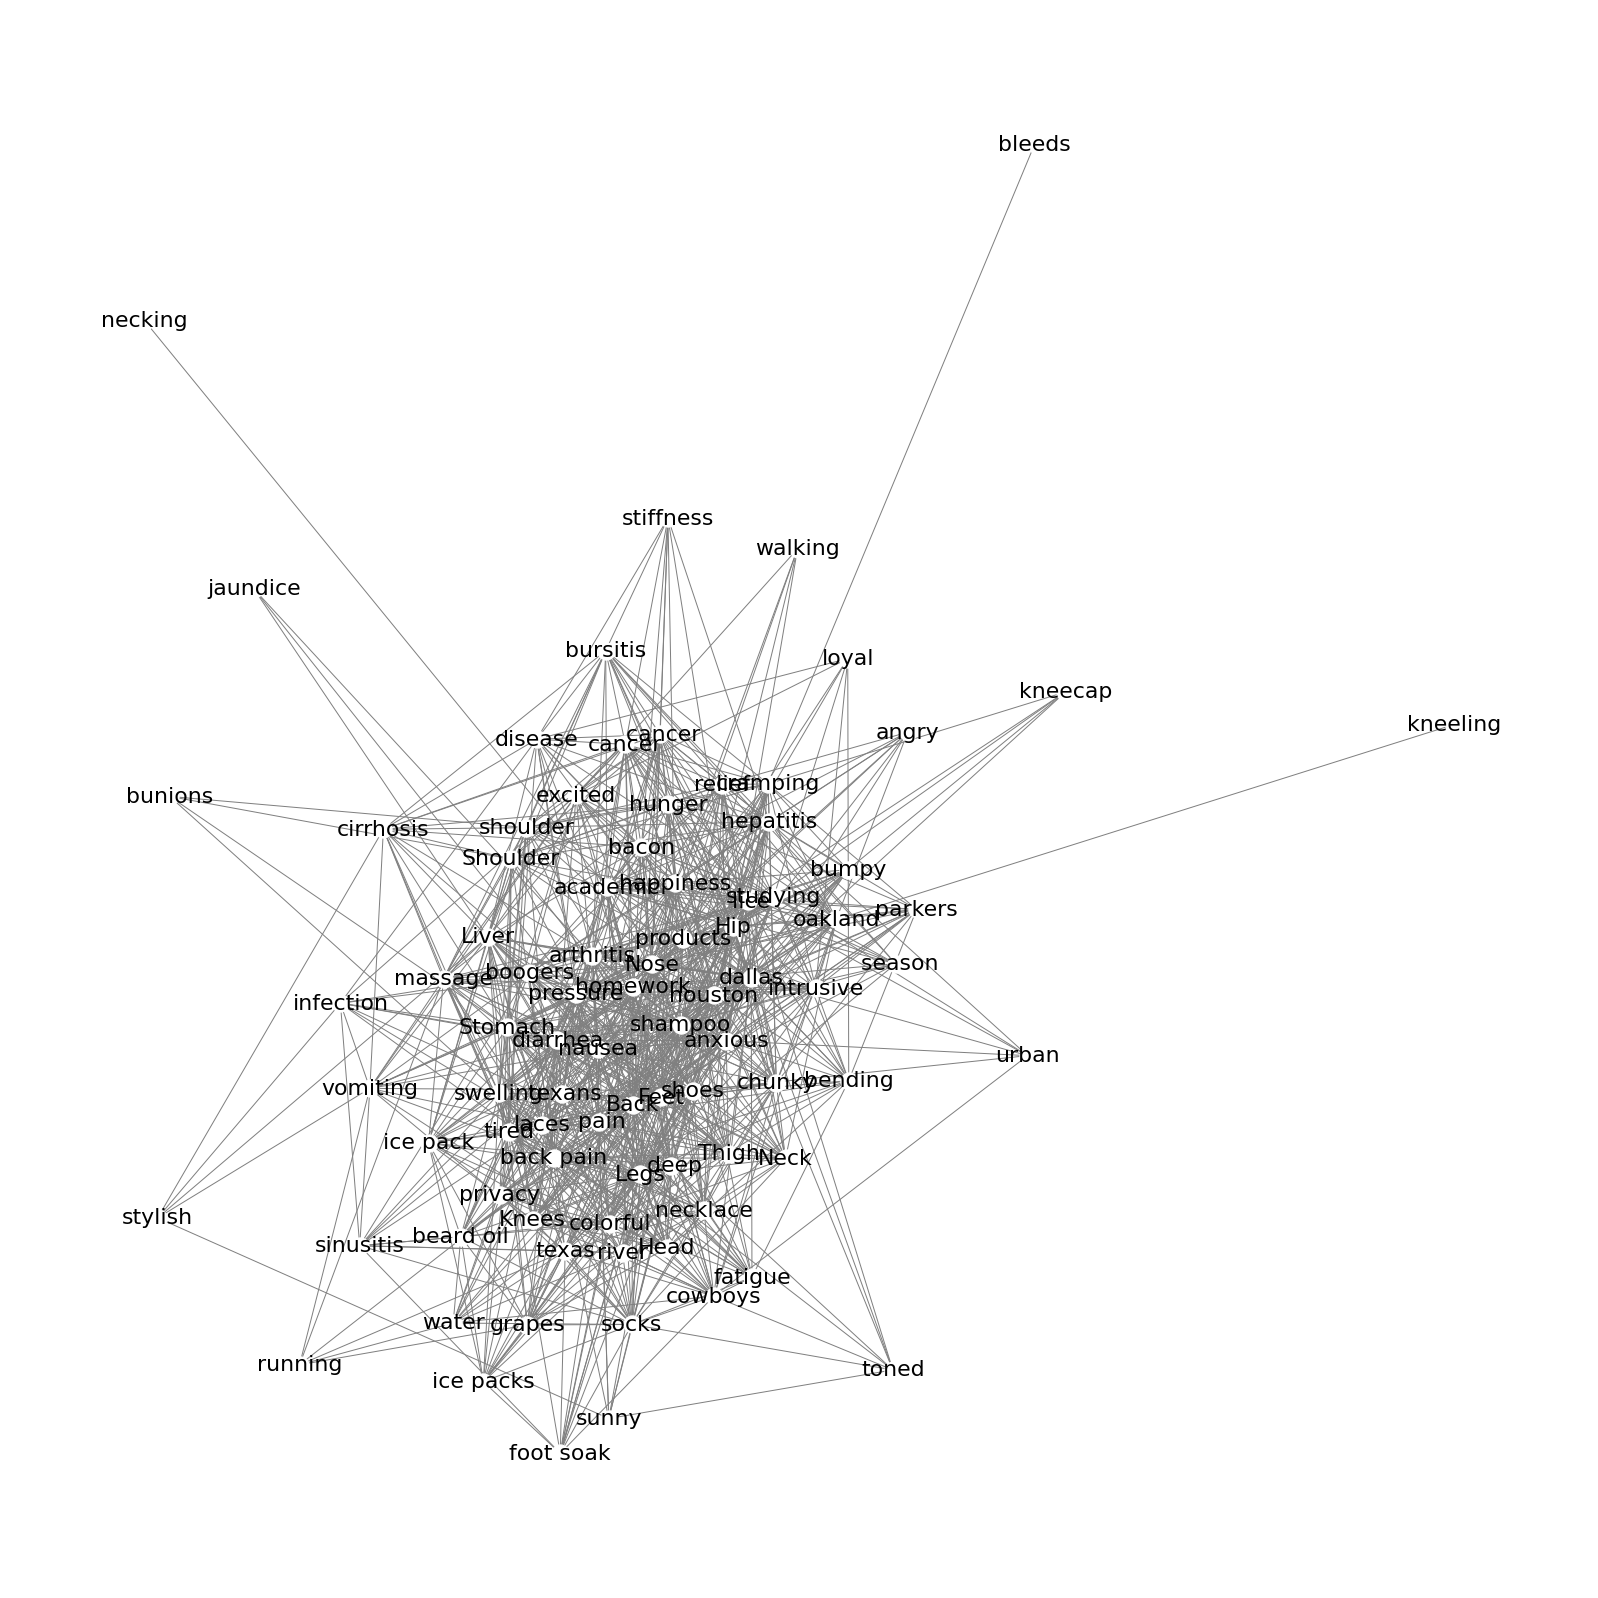

In [25]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']<0.85)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)

In [26]:
# community detection

# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

Communities found - 3 

Community 0 - [' pain', ' texans', 'Back', 'Feet', 'Head', 'Knees', 'Legs', 'Liver', 'Shoulder', 'Stomach', 'Thigh', 'anxious', 'arthritis', 'back pain', 'beard oil', 'bending', 'bunions', 'cirrhosis', 'colorful', 'diarrhea', 'fatigue', 'grapes', 'ice pack', 'ice packs', 'jaundice', 'pressure', 'privacy', 'products', 'shampoo', 'shoulder', 'swelling', 'tired']
Community 1 - [' cancer', ' lice', ' season', 'academic', 'angry', 'bleeds', 'bumpy', 'bursitis', 'cancer', 'cramping', 'dallas', 'disease', 'happiness', 'hepatitis', 'homework', 'houston', 'hunger', 'intrusive', 'kneecap', 'kneeling', 'loyal', 'necking', 'oakland', 'parkers', 'relief', 'stiffness', 'studying', 'urban']
Community 2 - [' deep', 'Hip', 'Neck', 'Nose', 'bacon', 'boogers', 'chunky', 'cowboys', 'excited', 'foot soak', 'infection', 'laces', 'massage', 'nausea', 'necklace', 'river', 'running', 'shoes', 'sinusitis', 'socks', 'stylish', 'sunny', 'texas', 'toned', 'vomiting', 'walking', 'water']


In [27]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice)
print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
print(gen_topics)


completed openai retrieval of batch 1 - 30 rows of 870

completed openai retrieval of batch 2 - 60 rows of 870

completed openai retrieval of batch 3 - 90 rows of 870

completed openai retrieval of batch 4 - 120 rows of 870

completed openai retrieval of batch 5 - 150 rows of 870

completed openai retrieval of batch 6 - 180 rows of 870

completed openai retrieval of batch 7 - 210 rows of 870

completed openai retrieval of batch 8 - 240 rows of 870

completed openai retrieval of batch 9 - 270 rows of 870

completed openai retrieval of batch 10 - 300 rows of 870

completed openai retrieval of batch 11 - 330 rows of 870

completed openai retrieval of batch 12 - 360 rows of 870

completed openai retrieval of batch 13 - 390 rows of 870

completed openai retrieval of batch 14 - 420 rows of 870

completed openai retrieval of batch 15 - 450 rows of 870

completed openai retrieval of batch 16 - 480 rows of 870

completed openai retrieval of batch 17 - 510 rows of 870

completed openai retrieva


completed retrieval of batch 1 - 30 rows of 429
failed to add topic - baconitis 

completed retrieval of batch 2 - 60 rows of 429
failed to add topic - beardruff 

completed retrieval of batch 3 - 90 rows of 429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



completed retrieval of batch 4 - 120 rows of 429

completed retrieval of batch 5 - 150 rows of 429
failed to add topic - sterism 

completed retrieval of batch 6 - 180 rows of 429

completed retrieval of batch 7 - 210 rows of 429
failed to add topic - bodylouse 

completed retrieval of batch 8 - 240 rows of 429

completed retrieval of batch 9 - 270 rows of 429

completed retrieval of batch 10 - 300 rows of 429

completed retrieval of batch 11 - 330 rows of 429
failed to add topic - downhomey 

completed retrieval of batch 12 - 360 rows of 429
failed to add topic - baconosis 

completed retrieval of batch 13 - 390 rows of 429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group with a single distinct value (8) having infinite probability density. Consider using a different visualization.
  "Consider using a different visualization.".format(val))
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group with a single distinct value (8.0) having infinite probability density. Consider using a different visualization.
  "Consider using a different visualization.".format(val))
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group wit

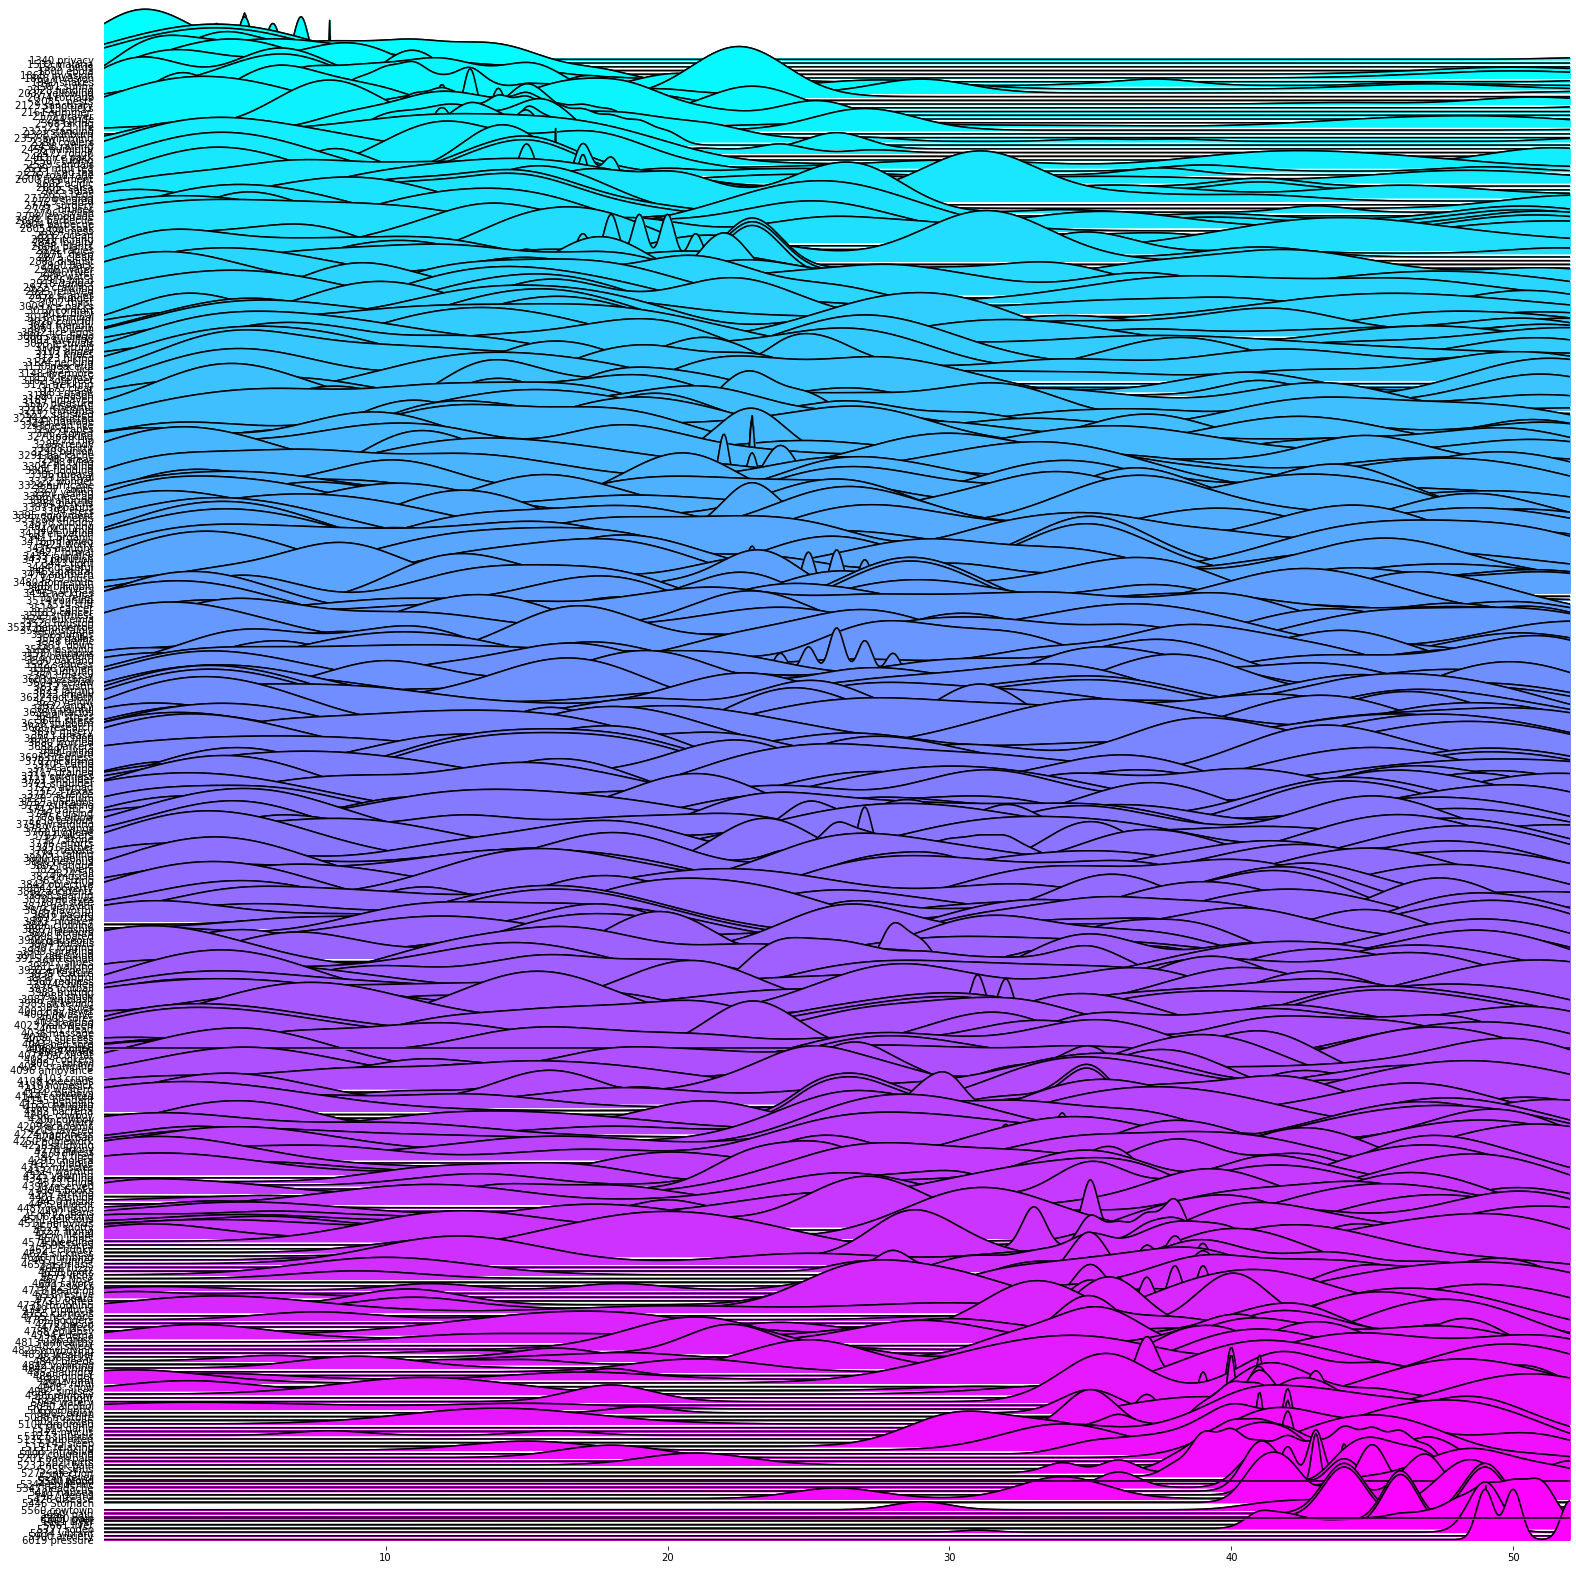

In [28]:
# request features
df_features = get_trend_frame(gen_topics, '5')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

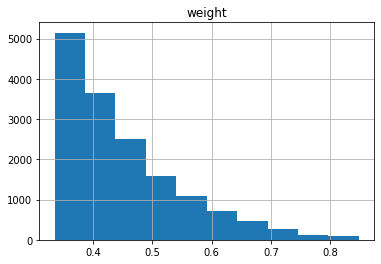

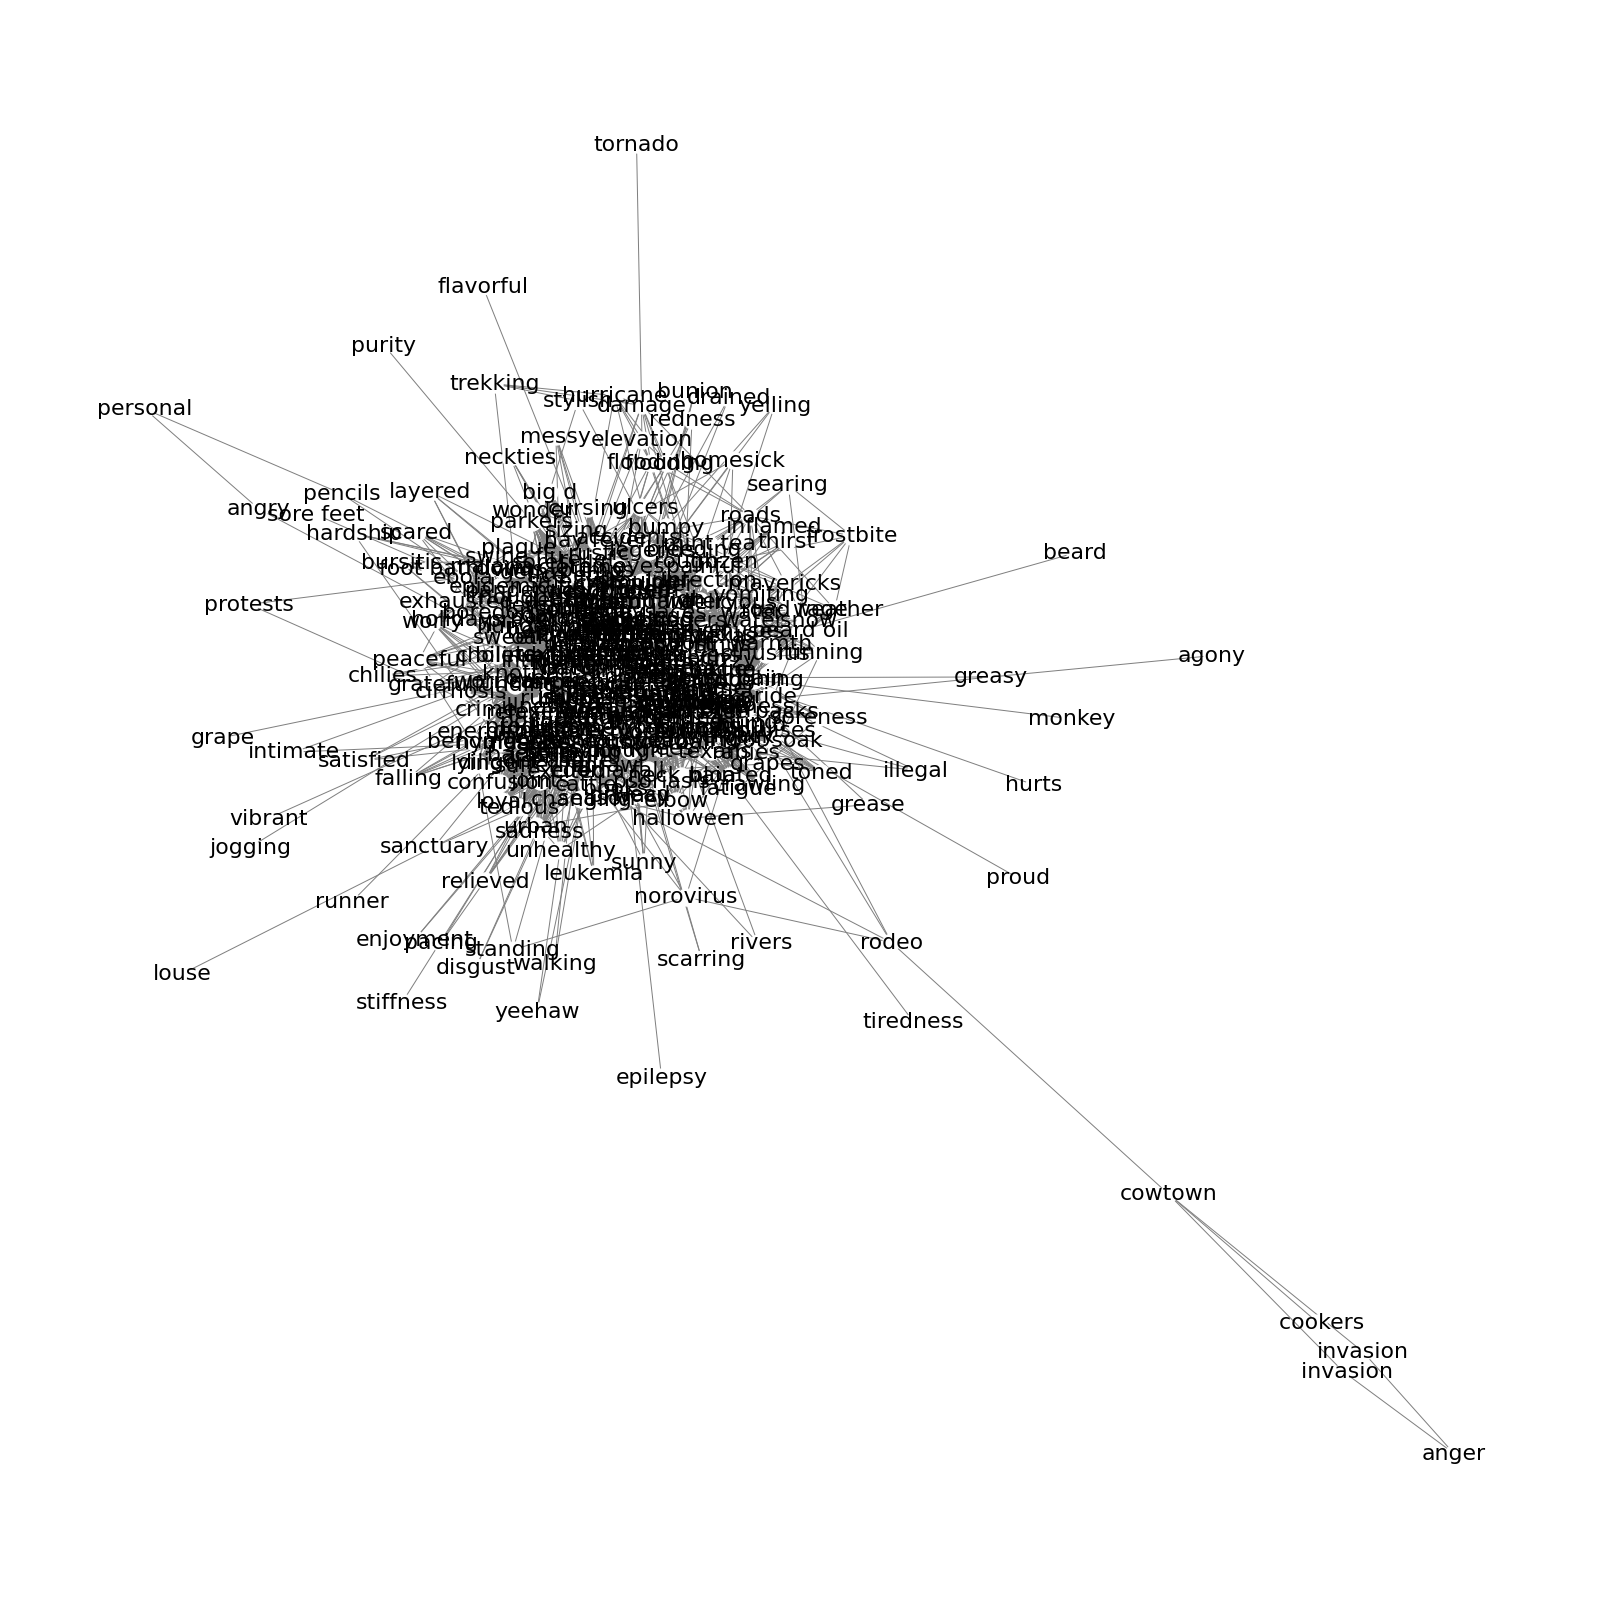

In [29]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor*2.8)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']<0.85)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)

In [30]:
# community detection

# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

Communities found - 6 

Community 0 - [' abroad', ' birds', ' cancer', ' days', ' down', ' legends', ' lice', ' over', ' pain', ' plants', ' surgery', ' ulcers', 'Back', 'Feet', 'Head', 'Hip', 'Knees', 'Liver', 'Neck', 'Nose', 'Shoulder', 'Stomach', 'Thigh', 'academic', 'accidents', 'alcohol', 'anxiety', 'anxious', 'arthritis', 'austin', 'back pain', 'big d', 'bilirubin', 'bleeding', 'bloated', 'blood', 'boogers', 'boredom', 'bumpy', 'bunion', 'bursitis', 'calming', 'cancer', 'cholera', 'chunky', 'cirrhosis', 'clothing', 'coffee', 'cramping', 'cursing', 'dallas', 'danger', 'deadly', 'dirty', 'drained', 'ebola', 'epidemic', 'exhausted', 'festivals', 'fever', 'flavorful', 'funding', 'garlic', 'germs', 'ginger', 'grape', 'grooming', 'hardship', 'hay fever', 'head lice', 'headache', 'hepatitis', 'houston', 'hunger', 'hurting', 'hurts', 'ibuprofen', 'infection', 'inflamed', 'intrusive', 'itchy', 'jogging', 'knotting', 'laces', 'laundry', 'layered', 'leukemia', 'lice eggs', 'liver', 'loyalty